# Google Trends Prediction using fbprophet

In [1]:
#Note: before launching Jupyter lab, need to export: export DJANGO_SETTINGS_MODULE=crypto_signal.settings
import django
django.setup()
# Matplotlib for plotting in the notebook
import matplotlib.pyplot as plt
from crypto_track.models import PyTrends

## Import the Prophet Class

In [2]:
from crypto_track.stocker import Prophet

### Pull and prep data

For this example, we will be looking at Google trends "Interest Over Time" metric for "Buy Bitcoin" vs. "BTC USD". To retrieve the data, we pull from CryptoTrends object and pass the dataframe to the prophet class. 

In [3]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("db.sqlite3")
df = pd.read_sql_query("select date as ds, btc_usd, buy_bitcoin, trend_ratio from crypto_track_pytrends;", conn)
df.head()

,ds,btc_usd,buy_bitcoin,trend_ratio
0,2018-05-02,9,2,0.22222
1,2018-05-03,10,3,0.30000
2,2018-05-04,9,3,0.33333
3,2018-05-05,10,3,0.30000
4,2018-05-06,8,2,0.25000


In [4]:
df['y'] = df['trend_ratio']
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df.head()

,ds,btc_usd,buy_bitcoin,trend_ratio,y
0,2018-05-02,9,2,0.22222,0.22222
1,2018-05-03,10,3,0.30000,0.30000
2,2018-05-04,9,3,0.33333,0.33333
3,2018-05-05,10,3,0.30000,0.30000
4,2018-05-06,8,2,0.25000,0.25000


In [5]:
df.dtypes

ds             datetime64[ns]
btc_usd                 int64
buy_bitcoin             int64
trend_ratio           float64
y                     float64
dtype: object

### Instantiate a Prophet object 

In [20]:
future_trend = Prophet(df, 'Trend Ratio')

Prophet Initialized. Data covers 2013-01-01 to 2018-12-02.


### Basic Plot of Trend History

We have a little over 5 years of history. Let's see what that looks like in its entirety.

Maximum trend_ratio = 17.00 on 2013-06-17.
Minimum trend_ratio = 0.16 on 2018-02-06.
Current trend_ratio = 0.31 on 2018-12-02.



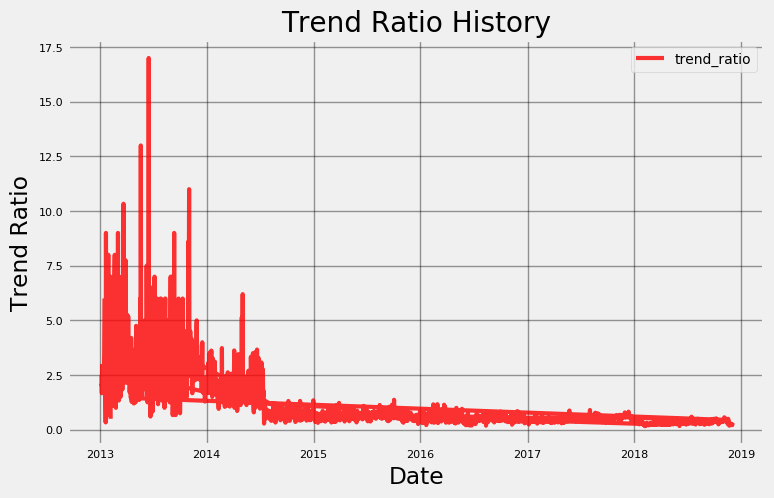

In [21]:
future_trend.plot_chart(stats=['trend_ratio'])

## Examine Trends/Patterns

We can create a basic model (with no predictions) trained on the past 4 years of data to inspect any trends and patterns in the data. 

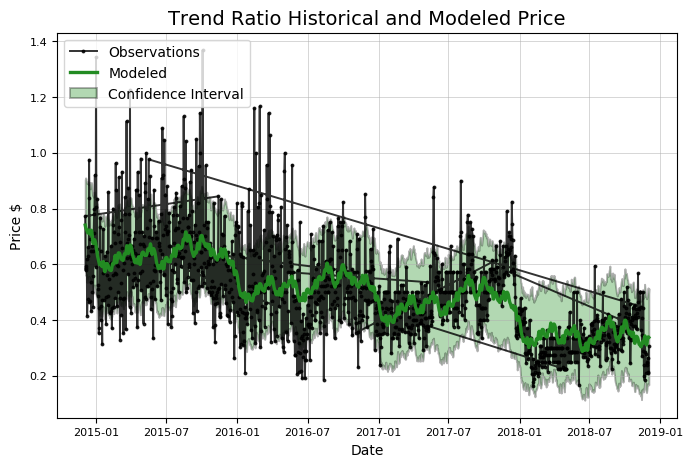

In [22]:
future_trend.training_years=4
model, model_data = future_trend.create_prophet_model()

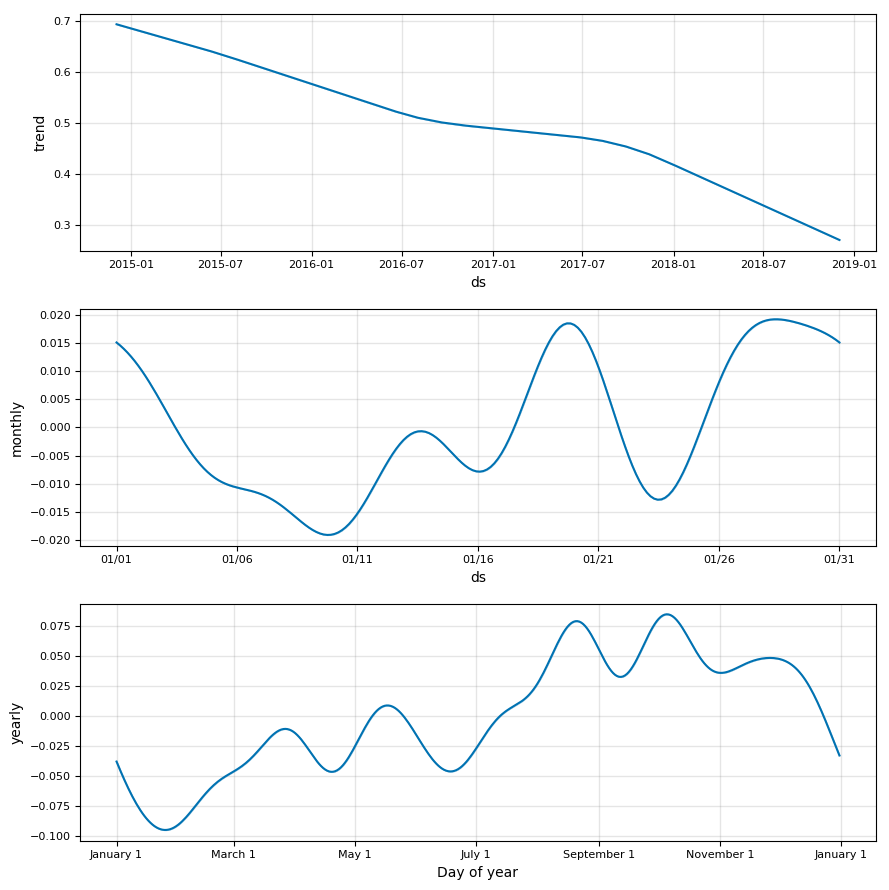

In [23]:
# Variables assigned from previous method call
model.plot_components(model_data)
plt.show()

### Test Addition of a Weekly Seasonality

Although it is unlikely, there might be a significant weekly component which would improve the model. Let's add it in and look at the pattern. 

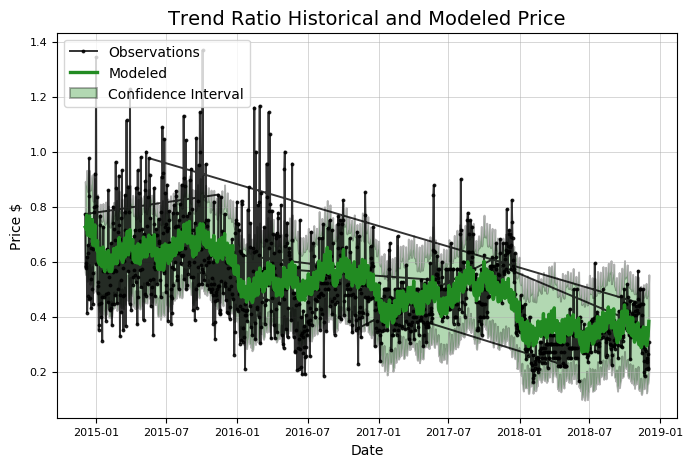

In [24]:
future_trend.weekly_seasonality=True
model, model_data = future_trend.create_prophet_model()

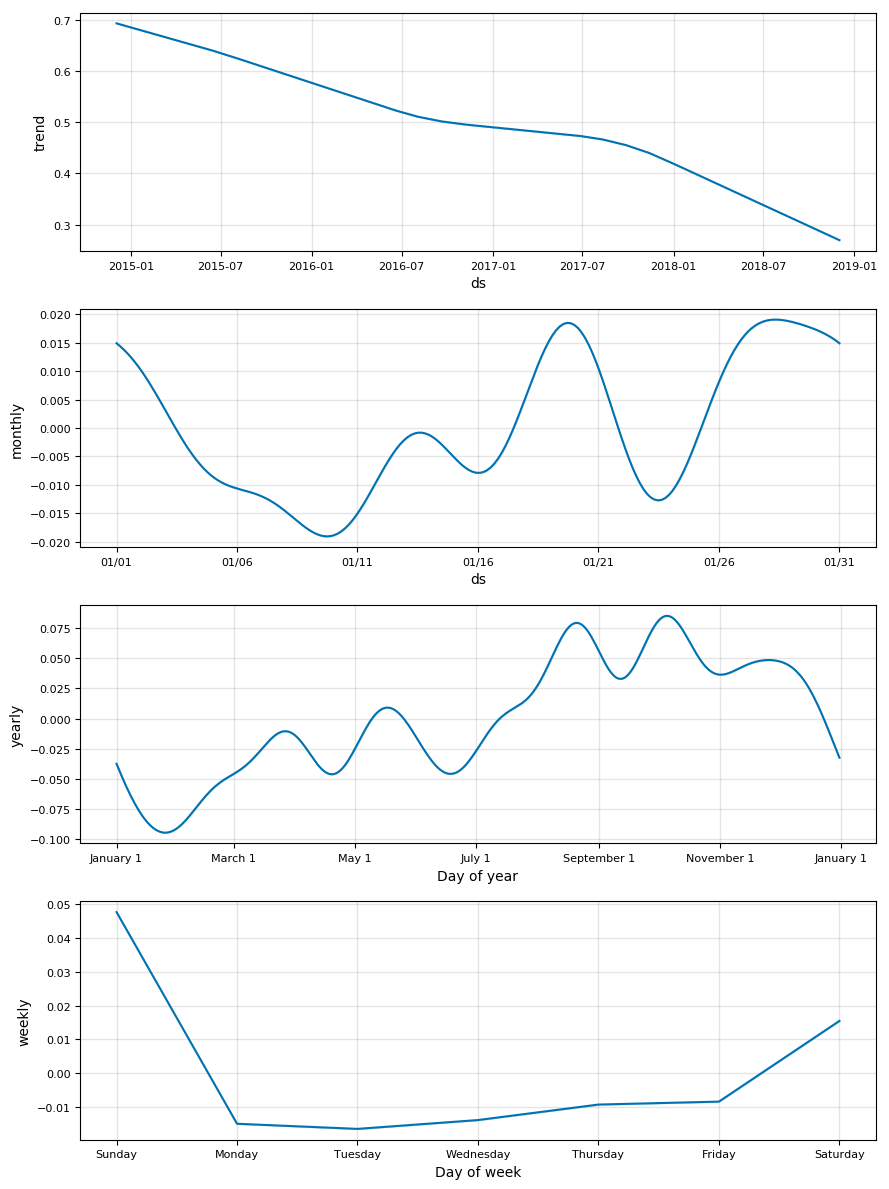

In [25]:
model.plot_components(model_data)
plt.show()

We will keep weekly seasonality as it looks like there is a hike on the weekends.

# First Predictions

We can make a prediction for any number of specified days using the create model method. The prediction also includes the uncertainty interval, a necessity when making estimates about the future! 

Predicted Value on 2019-03-02 = $0.22


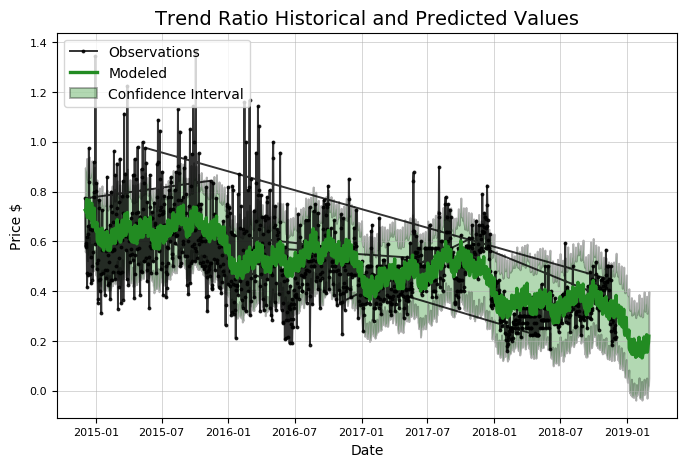

In [26]:
model, model_data = future_trend.create_prophet_model(days=90)

# Evaluate Model

For our predictions to be meaningful, we must evaluate them on real data. 

One way to do this is set aside some historical data as a test set and use data from further back as our training set. In the default evaluation method, we test using the past year and train on the 4 years prior to the test period. 

When the model predicted an increase, the price increased 50.23% of the time.
When the model predicted a  decrease, the price decreased  51.02% of the time.


Prediction Range: 2017-12-02 to 2018-12-02.

Predicted value on 2018-12-01 = $0.66.
Actual value on    2018-12-01 = $0.21.

Average Absolute Error on Training Data = $0.20.
Average Absolute Error on Testing  Data = $0.20.

The actual value was within the 80% confidence interval 98.36% of the time.


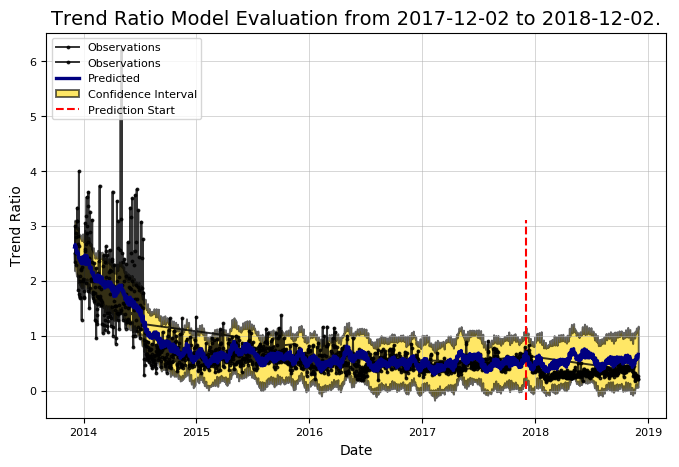

In [29]:
future_trend.view_prediction();

# Changepoint Prior Scale Selection

Changepoints represent where a time series goes from increasing to decreasing or from increasing slowly to increasingly rapidly. They occur at the places with the [greatest change in the rate of the time series](https://facebook.github.io/prophet/docs/trend_changepoints.html). 

The changepoint prior scale represents the amount of weight given to the changepoints in the model. This can be used to control overfitting vs underfitting. A higher prior will create a model with more flexibility and more emphasis on the changepoints. This can lead to overfitting because the model will closely follow the training data. Lowering the prior decreases the model flexibility which can cause the opposite problem underfitting. This occurs when our model does not follow the training data closely enough and fails to learn the underlying relationships.

## Graphical Comparison

We will start with a range of four priors to compare. First, we can graphically compare them to get an intuition of how the priors affect the model.  

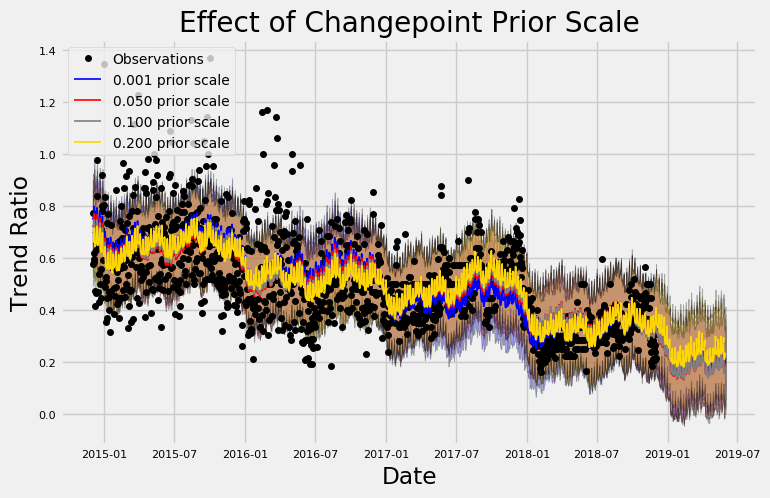

In [30]:
future_trend.changepoint_prior_analysis(changepoint_priors=[0.001, 0.05, 0.1, 0.2])

## Quantitative Comparison

This gives us an idea of how well each prior fits the training data, but no numbers to back up our intuitions. The changepoint prior validation method is designed to provide numerical backing. We are testing from 2017-12-02 to 2018-12-02, so we need to make sure to use a different validation range. We will select two years prior to the testing date range. The model will be trained on the three years prior to the validation period.

/Users/lauramay/Documents/GitHub/crypto_signal/env/lib/python3.7/site-packages/pandas/core/frame.py:406: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  elif isinstance(data, collections.Iterator):



Validation Range 2016-12-02 to 2017-12-02.

     cps  train_err  train_range  test_err  test_range
0  0.001   0.721118     3.007215  1.267273    3.007954
1  0.050   0.538846     2.600518  0.173679    2.627782
2  0.100   0.534034     2.591518  0.183275    2.632548
3  0.200   0.531449     2.589638  0.218546    2.642191


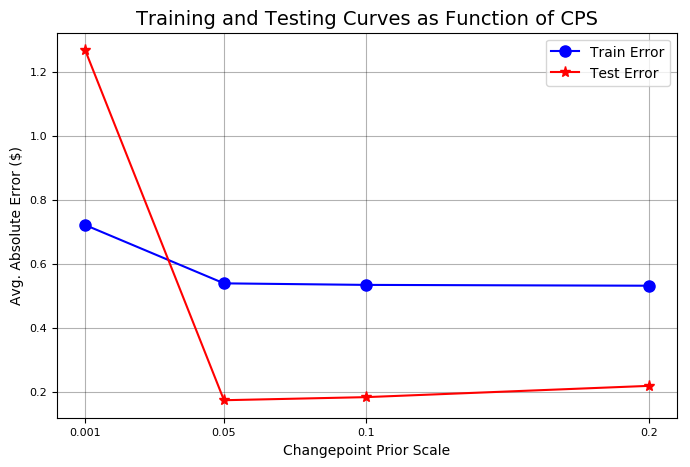

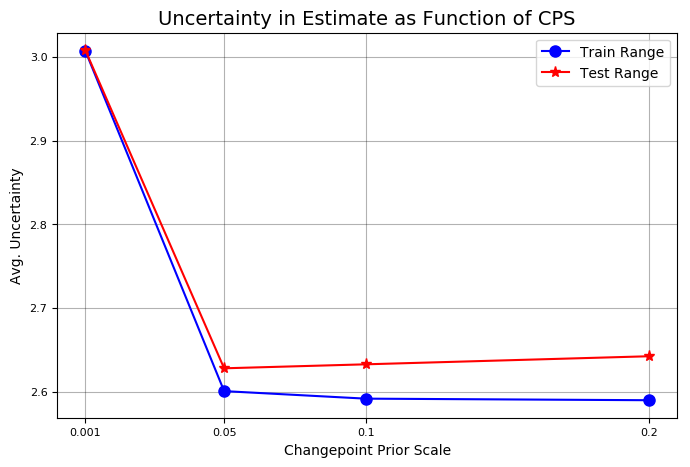

In [31]:
future_trend.changepoint_prior_validation(changepoint_priors=[0.001, 0.05, 0.1, 0.2])

The test error decreases as we increase the prior.

### Refine Search 

We can evaluate additional changepoint prior scales to determine the best fit for our data. 


Validation Range 2016-12-02 to 2017-12-02.

    cps  train_err  train_range  test_err  test_range
0  0.05   0.538846     2.598473  0.173679    2.623631
1  0.15   0.532803     2.591027  0.195880    2.635396
2  0.20   0.531449     2.587383  0.218546    2.642236
3  0.40   0.523518     2.574864  0.196126    3.080578
4  0.50   0.523185     2.570551  0.198253    3.135773
5  0.60   0.520385     2.562844  0.196124    3.512798


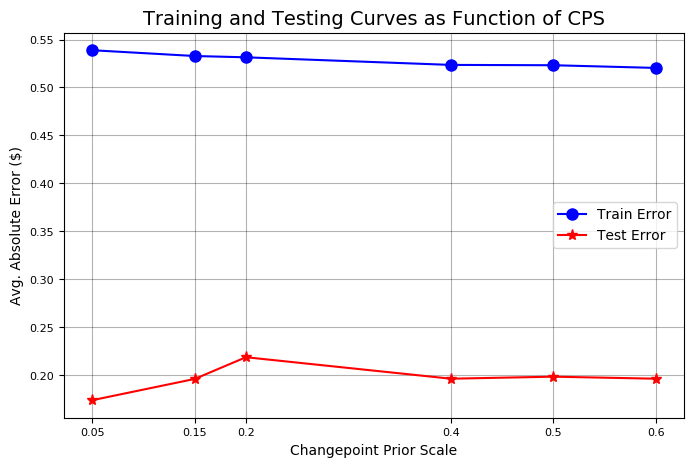

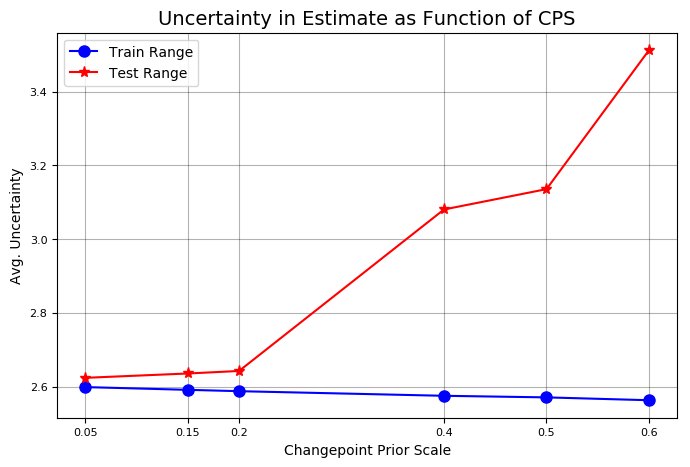

In [32]:
future_trend.changepoint_prior_validation(changepoint_priors=[0.05, 0.15, 0.2, 0.4, 0.5, 0.6])

We now assign the changepoint prior with the smallest error on the testing set to the bitcoin object. The prior is one of the attiributes and we can change it like any other variable. At this point, we could also change the seasonalities or the amount of training data to achieve the best performance on the testing data

### Evaluate Improved Model
Evaluating model with 0.05 changepoint because it had the lowest test error and uncertainty range.

When the model predicted an increase, the price increased 50.23% of the time.
When the model predicted a  decrease, the price decreased  51.02% of the time.


Prediction Range: 2017-12-02 to 2018-12-02.

Predicted value on 2018-12-01 = $0.66.
Actual value on    2018-12-01 = $0.21.

Average Absolute Error on Training Data = $0.20.
Average Absolute Error on Testing  Data = $0.20.

The actual value was within the 80% confidence interval 97.81% of the time.


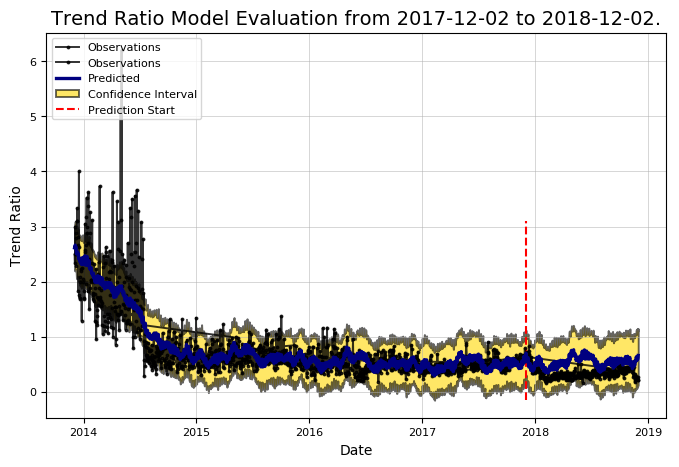

In [35]:
future_trend.changepoint_prior_scale = 0.05
future_trend.view_prediction();

When the model predicted an increase, the price increased 50.46% of the time.
When the model predicted a  decrease, the price decreased  51.37% of the time.


Prediction Range: 2017-12-02 to 2018-12-02.

Predicted value on 2018-12-01 = $0.69.
Actual value on    2018-12-01 = $0.21.

Average Absolute Error on Training Data = $0.19.
Average Absolute Error on Testing  Data = $0.21.

The actual value was within the 80% confidence interval 99.73% of the time.


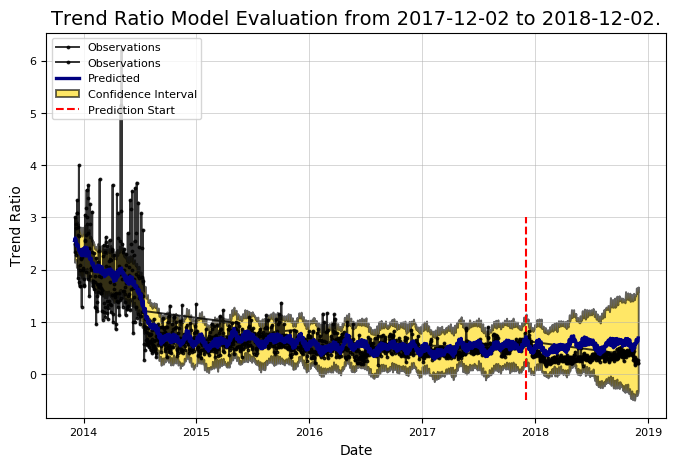

In [37]:
future_trend.changepoint_prior_scale=0.15
future_trend.view_prediction();

# Predict the Future

As a last step, we can predict any number of days into the future. This function automatically trains on the past 4 years and makes predictions with the uncertainty intervals. 


Predicted Increase: 

           Date  estimate    change     upper     lower
1460 2018-12-02  0.398369  0.031429  0.561958  0.239327
1466 2018-12-08  0.337928  0.019754  0.495886  0.166371
1467 2018-12-09  0.367681  0.029753  0.534094  0.204004
1471 2018-12-13  0.297291  0.003196  0.462502  0.136269
1472 2018-12-14  0.301146  0.003854  0.476428  0.140435
1473 2018-12-15  0.329717  0.028571  0.504014  0.162992
1474 2018-12-16  0.363533  0.033816  0.529094  0.194958
1478 2018-12-20  0.291658  0.006089  0.453577  0.132512
1479 2018-12-21  0.298966  0.007308  0.457455  0.140268
1480 2018-12-22  0.327477  0.028511  0.486971  0.154633
1481 2018-12-23  0.355844  0.028367  0.514800  0.182146
1485 2018-12-27  0.252408  0.001105  0.410699  0.086508
1486 2018-12-28  0.257428  0.005020  0.428404  0.106526
1487 2018-12-29  0.287307  0.029879  0.444114  0.124660
1488 2018-12-30  0.322175  0.034868  0.481098  0.162691

Predicted Decrease: 

           Date  estimate    change     upper     lower
14

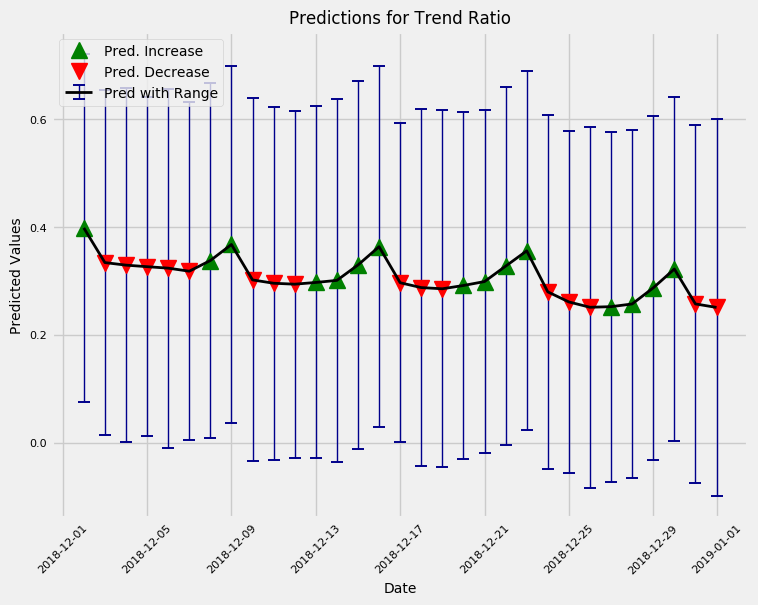

In [38]:
future_trend.predict_future(days=30);